# Homework 6
## Yue Peng

Use the data from the iod.csv file you analyzed in the previous homework to create
a model for GFR that considers nonlinear transformations (polynomials, step functions,
splines, generalized additive models) for continuous predictors. Try each type of nonlinear
function and give statistical support (e.g, by using a hypothesis test) to your final choice.
If the function is nonparametric or hard to interpret, try to represent it using a function
that can be interpreted straightforwardly.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import scale

c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s \times %s" % (round(coef, 5), name)
                                   for coef, name in lst)

# def printmd(string):
#     display(Markdown(string))

We will use the **_sklearn_** package in order to perform ridge regression and the lasso.

In [3]:
data = pd.read_csv('iodatadev.csv')

Loading the data set from two kidney disease studies, and use these variables were given

In [4]:
vars = ["WEIGHT", "BMI", "GFR", "UCRE", "UUN", "UPHO", "SUN", "SCR", "TCHOL", "ALB", "HBA1C", "PHOS",
         "TRIG", "LDL", "HDL", "HB", "MAP", "upro", "BSA", "SODIUM", "GLUC", "BLACK", "HEIGHT", "AGE",
         "FEMALE", "cys", "DBP", "SBP", "CRP", "Diabetes", "hbpstatus"]

In [5]:
data = data[vars]
data.shape

(2749, 31)

Before proceeding, let’s first ensure that the missing values in the data set.

In [6]:
for i in vars:
    print('%s has %d missing values' % (i, sum(data[i].isna())))

WEIGHT has 0 missing values
BMI has 190 missing values
GFR has 0 missing values
UCRE has 630 missing values
UUN has 673 missing values
UPHO has 1888 missing values
SUN has 263 missing values
SCR has 6 missing values
TCHOL has 869 missing values
ALB has 490 missing values
HBA1C has 2106 missing values
PHOS has 819 missing values
TRIG has 2100 missing values
LDL has 2104 missing values
HDL has 2104 missing values
HB has 646 missing values
MAP has 630 missing values
upro has 840 missing values
BSA has 495 missing values
SODIUM has 686 missing values
GLUC has 576 missing values
BLACK has 0 missing values
HEIGHT has 1 missing values
AGE has 0 missing values
FEMALE has 0 missing values
cys has 0 missing values
DBP has 440 missing values
SBP has 440 missing values
CRP has 1018 missing values
Diabetes has 1 missing values
hbpstatus has 1726 missing values


We decide to drop some variables due to the large amount of missing data but keeping the original dataset as many as possible

In [7]:
dat = data[["WEIGHT", "BMI", "GFR", "UCRE", "UUN", "SUN", "SCR", "TCHOL", "ALB", "PHOS",
          "HB", "MAP", "upro", "BSA", "SODIUM", "GLUC", "BLACK", "HEIGHT", "AGE",
         "FEMALE", "cys", "DBP", "SBP", "Diabetes"]]

In [8]:
dat = dat.dropna()

In [9]:
X = dat[["WEIGHT", "BMI", "UCRE", "UUN", "SUN", "SCR", "TCHOL", "ALB", "PHOS",
          "HB", "MAP", "upro", "BSA", "SODIUM", "GLUC", "BLACK", "HEIGHT", "AGE",
         "FEMALE", "cys", "DBP", "SBP", "Diabetes"]]
y = dat["GFR"]

In [10]:
print("Finally we keep %.2f of data points with keeping %d/30 predicors" %(X.shape[0]/data.shape[0], X.shape[1]))

Finally we keep 0.57 of data points with keeping 23/30 predicors


We first split the samples into a training set and a test set in order to estimate the test error of each regression:

In [11]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Lasso Regression

We will now perform lasso regression in order to predict GFR with feature selection on the data

We now perform *10-fold* cross-validation to choose the best alpha, refit the model, and compute the associated test error:

We use the *LassoCV* object that sets its $\lambda$ parameter automatically from the data by internal cross-validation (i.e. it performs cross-validation on the training data it receives).

In [12]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)

In [13]:
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=1, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [14]:
lasso = Lasso(max_iter=10000, normalize=True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print("The test data MSE is %.2f" % (mean_squared_error(y_test, lasso.predict(X_test))))
print("The test data R-squared is %.2f" % (lasso.score(X_test, y_test)))

The test data MSE is 149.89
The test data R-squared is 0.72


In [15]:
lasso.fit(X, y)

Lasso(alpha=0.0047921371130301661, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
pretty_print_linear(lasso.coef_, list(X.columns), sort = True)

'-13.64599 \times cys + 5.95952 \times BLACK + -4.30164 \times SCR + -3.46714 \times FEMALE + 2.8663 \times ALB + 1.59638 \times PHOS + -0.20604 \times SUN + 0.12258 \times HB + 0.0848 \times UUN + -0.08286 \times AGE + 0.05791 \times SODIUM + -0.01942 \times HEIGHT + 0.01148 \times GLUC + 0.00694 \times BMI + 0.0034 \times UCRE + -0.00271 \times TCHOL + -0.00032 \times upro + 0.0 \times WEIGHT + 0.0 \times MAP + -0.0 \times BSA + 0.0 \times DBP + 0.0 \times SBP + 0.0 \times Diabetes'

$$GFR = $-13.64599 \times cys + 5.95952 \times BLACK + -4.30164 \times SCR +$$

$$-3.46714 \times FEMALE + 2.8663 \times ALB + 1.59638 \times PHOS + -0.20604 \times SUN +$$

$$0.12258 \times HB + 0.0848 \times UUN + -0.08286 \times AGE + 0.05791 \times SODIUM +$$

$$-0.01942 \times HEIGHT + 0.01148 \times GLUC + 0.00694 \times BMI + 0.0034 \times UCRE +$$

$$-0.00271 \times TCHOL + -0.00032 \times upro + 0.0 \times WEIGHT + 0.0 \times MAP +$$

$$-0.0 \times BSA + 0.0 \times DBP + 0.0 \times SBP + 0.0 \times Diabetes$$

This is substantially lower than the test set MSE of stepwise regression, and lower than the test set MSE of ridge regression with $\lambda$ chosen by cross-validation.

Also, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that the coefficient estimates of **WEIGHT**, **MAP**, **BSA**, **DBP**, **SBP** and **Diabetes** are exactly zero. The other factors are predictive. This model predicts the data quite well with _MSE = 149.89_ and _R-Squared = 0.72_

We selected some significant variables whose absoulte value of their coefficient are greater than one

In [17]:
vars_selected = ["SCR", "ALB", "PHOS", "BLACK", "FEMALE", "cys"]

In [18]:
X_train = X_train[vars_selected]
X_test = X_test[vars_selected]

In [19]:
X_train.head()

,SCR,ALB,PHOS,BLACK,FEMALE,cys
2164,2.2,4.4,3.2,1,0,2.23
1181,2.6,4.5,3.0,1,0,1.33
2485,2.7,3.2,4.1,1,1,2.83
1004,1.2,4.1,2.9,0,1,1.23
1953,2.4,4.3,3.1,1,1,1.94


We could know that **cys**, **ALB**, **PHOS** and **SCR** are continuous predictors.

### Polynomial

In [20]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

Quadratic polynomial

In [21]:
poly_reg = PolynomialFeatures(degree = 2)
X_train_poly = poly_reg.fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X_test_poly = poly_reg.fit_transform(X_test[["cys", "ALB", "PHOS", "SCR"]])

In [22]:
lin_reg_2 = linear_model.LinearRegression()
lin_reg_2.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
print("The test data MSE is %.2f" % (mean_squared_error(y_test, lin_reg_2.predict(X_test_poly))))
print("The test data R-squared is %.2f" % (lin_reg_2.score(X_test_poly, y_test)))

The test data MSE is 118.37
The test data R-squared is 0.78


Cubic polynomial

In [24]:
poly_reg3 = PolynomialFeatures(degree = 3)
X_train_poly3 = poly_reg3.fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X_test_poly3 = poly_reg3.fit_transform(X_test[["cys", "ALB", "PHOS", "SCR"]])

In [25]:
lin_reg_3 = linear_model.LinearRegression()
lin_reg_3.fit(X_train_poly3, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
print("The test data MSE is %.2f" % (mean_squared_error(y_test, lin_reg_3.predict(X_test_poly3))))
print("The test data R-squared is %.2f" % (lin_reg_3.score(X_test_poly3, y_test)))

The test data MSE is 109.13
The test data R-squared is 0.79


The cubic polynomial method has a better capacity to test the nonlinearity since it has less _MSE_ and _R-squared_ 

### Deciding on a degree

We can do this using the __anova\_lm()__ function, which performs an analysis of variance (ANOVA, using an F-test) in order to test the null hypothesis that a model Model 1 is sufficient to explain the data against the alternative hypothesis that a more complex model Model 2 is required.

In [27]:
import statsmodels.api as sm

In [28]:
X1 = PolynomialFeatures(1).fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X2 = PolynomialFeatures(2).fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X3 = PolynomialFeatures(3).fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X4 = PolynomialFeatures(4).fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])
X5 = PolynomialFeatures(5).fit_transform(X_train[["cys", "ALB", "PHOS", "SCR"]])

In [29]:
fit_1 = fit = sm.GLS(y_train, X1).fit()
fit_2 = fit = sm.GLS(y_train, X2).fit()
fit_3 = fit = sm.GLS(y_train, X3).fit()
fit_4 = fit = sm.GLS(y_train, X4).fit()
fit_5 = fit = sm.GLS(y_train, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid            ssr  df_diff       ss_diff          F        Pr(>F)
0    1088.0  184952.160654      0.0           NaN        NaN           NaN
1    1078.0  131444.445275     10.0  53507.715379  47.842629  3.438929e-79
2    1058.0  120039.870896     20.0  11404.574380   5.098562  2.671357e-12
3    1023.0  115066.228375     35.0   4973.642520   1.270589  1.363428e-01
4     967.0  108150.329846     56.0   6915.898529   1.104229  2.827319e-01


c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The p-value comparing the linear Model 1 to the quadratic Model 2 is essentially zero ($<10−78$), indicating that a linear fit is not sufficient. Similarly the p-value comparing the quadratic Model 2 to the cubic Model 3 is very low ($<10-11$), so the quadratic fit is also insufficient. The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately $0.01$ while the degree-5 polynomial Model 5 seems unnecessary because its p-value is $0.28$. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

### Step function

In order to fit a step function, we use the $cut()$ function:

First, we deal with the **cys** predictor

In [30]:
df_cut, bins = pd.cut(X_train.cys, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)
df_steps = pd.concat([X_train.cys, df_cut, y_train], keys = ['cys','cys_cuts','GFR'], axis = 1)

# Create dummy variables for the cys groups
df_steps_dummies = pd.get_dummies(df_steps['cys_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

fit1 = sm.GLM(df_steps.GFR, df_steps_dummies).fit()
fit1.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,2.858e+13,1.64e+14,0.174,0.862,-2.93e+14,3.51e+14
"(0.515, 1.71]",-2.858e+13,1.64e+14,-0.174,0.862,-3.51e+14,2.93e+14
"(1.71, 2.9]",-2.858e+13,1.64e+14,-0.174,0.862,-3.51e+14,2.93e+14
"(2.9, 4.09]",-2.858e+13,1.64e+14,-0.174,0.862,-3.51e+14,2.93e+14
"(4.09, 5.28]",-2.858e+13,1.64e+14,-0.174,0.862,-3.51e+14,2.93e+14


Then, we deal with the **ALB** predictor

In [31]:
df_cut, bins = pd.cut(X_train.ALB, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)
df_steps = pd.concat([X_train.ALB, df_cut, y_train], keys = ['ALB','ALB_cuts','GFR'], axis = 1)

# Create dummy variables for the cys groups
df_steps_dummies = pd.get_dummies(df_steps['ALB_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

fit2 = sm.GLM(df_steps.GFR, df_steps_dummies).fit()
fit2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,35.8918,0.811,44.241,0.000,34.302,37.482
"(2.798, 3.425]",-5.0783,2.567,-1.978,0.048,-10.110,-0.047
"(3.425, 4.05]",2.7367,1.229,2.226,0.026,0.327,5.146
"(4.05, 4.675]",15.5430,1.047,14.850,0.000,13.492,17.594
"(4.675, 5.3]",22.6905,1.819,12.476,0.000,19.126,26.255


Then, we deal with the **PHOS** predictor

In [32]:
df_cut, bins = pd.cut(X_train.PHOS, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)
df_steps = pd.concat([X_train.PHOS, df_cut, y_train], keys = ['PHOS','PHOS_cuts','GFR'], axis = 1)

# Create dummy variables for the cys groups
df_steps_dummies = pd.get_dummies(df_steps['PHOS_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

fit3 = sm.GLM(df_steps.GFR, df_steps_dummies).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,30.3083,5.971,5.076,0.000,18.606,42.011
"(1.289, 4.125]",21.1079,5.996,3.520,0.000,9.356,32.860
"(4.125, 6.95]",0.7430,6.077,0.122,0.903,-11.167,12.653
"(6.95, 9.775]",-21.7953,17.385,-1.254,0.210,-55.870,12.279
"(9.775, 12.6]",30.2527,17.385,1.740,0.082,-3.822,64.327


Then, we deal with the **SCR** predictor

In [33]:
df_cut, bins = pd.cut(X_train.SCR, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)
df_steps = pd.concat([X_train.SCR, df_cut, y_train], keys = ['SCR','SCR_cuts','GFR'], axis = 1)

# Create dummy variables for the cys groups
df_steps_dummies = pd.get_dummies(df_steps['SCR_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

fit4 = sm.GLM(df_steps.GFR, df_steps_dummies).fit()
fit4.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,8.471e+13,1.87e+14,0.454,0.650,-2.81e+14,4.5e+14
"(0.794, 2.35]",-8.471e+13,1.87e+14,-0.454,0.650,-4.5e+14,2.81e+14
"(2.35, 3.9]",-8.471e+13,1.87e+14,-0.454,0.650,-4.5e+14,2.81e+14
"(3.9, 5.45]",-8.471e+13,1.87e+14,-0.454,0.650,-4.5e+14,2.81e+14
"(5.45, 7.0]",-8.471e+13,1.87e+14,-0.454,0.650,-4.5e+14,2.81e+14


According to the tables above, we choose **ALB** variables to analyse since its p-values are all less than $0.05$.

In [34]:
df_cut, bins = pd.cut(X_test.ALB, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)
df_steps = pd.concat([X_test.ALB, df_cut, y_test], keys = ['ALB','ALB_cuts','GFR'], axis = 1)

# Create dummy variables for the cys groups
df_steps_dummies = pd.get_dummies(df_steps['ALB_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

In [35]:
mean_squared_error(y_test, fit2.predict(df_steps_dummies))

466.83181274503551

Since the $MSE$ is quite large, it is not flexible and efficient to use step function here.

### Spline

In [36]:
min(X_train.ALB), max(X_train.ALB)

(2.8, 5.3)

In [14]:
from patsy import dmatrix

# Specifying 3 knots
transformed_x_train = dmatrix("bs(X_train.ALB, knots=(3,3.5, 4,4.5, 5), degree=3, include_intercept=False)",
                        {"X_train.ALB": X_train.ALB}, return_type='dataframe')
transformed_x_test = dmatrix("bs(X_test.ALB, knots=(3,3.5, 4,4.5, 5), degree=3, include_intercept=False)",
                        {"X_test.ALB": X_test.ALB}, return_type='dataframe')
# Build a regular linear model from the splines
fits1 = sm.GLM(y_train, transformed_x_train).fit()
fits1.params

Intercept                                                                           70.450704
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[0]   -34.683821
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[1]   -41.856123
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[2]   -39.404772
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[3]   -29.464482
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[4]   -10.703902
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[5]   -12.636677
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[6]   -10.596142
bs(X_train.ALB, knots=(3, 3.5, 4, 4.5, 5), degree=3, include_intercept=False)[7]   -14.648469
dtype: float64

In [15]:
mean_squared_error(y_test, fits1.predict(transformed_x_test))

466.5912955648206

In this case python chooses knots which correspond to the 25th, 50th, and 75th percentiles. The default degree is 3 (which yields a cubic spline).

In [39]:
# Specifying 6 degrees of freedom 
transformed_x_train1 = dmatrix("bs(X_train.ALB, df=6, include_intercept=False)",
                        {"X_train.ALB": X_train.ALB}, return_type='dataframe')
transformed_x_test2 = dmatrix("bs(X_test.ALB, df=6, include_intercept=False)",
                        {"X_test.ALB": X_test.ALB}, return_type='dataframe')
fits2 = sm.GLM(y_train, transformed_x_train1).fit()
fits2.params

Intercept                                            53.308028
bs(X_train.ALB, df=6, include_intercept=False)[0]   -39.576361
bs(X_train.ALB, df=6, include_intercept=False)[1]   -16.386697
bs(X_train.ALB, df=6, include_intercept=False)[2]    -6.098438
bs(X_train.ALB, df=6, include_intercept=False)[3]    11.280441
bs(X_train.ALB, df=6, include_intercept=False)[4]     1.330646
bs(X_train.ALB, df=6, include_intercept=False)[5]     6.397505
dtype: float64

In [40]:
mean_squared_error(y_test, fits2.predict(transformed_x_test2))

467.62042344470427

### GAM

In [41]:
from pygam import LinearGAM
from pygam.utils import generate_X_grid

In [42]:
gam = LinearGAM().fit(X_train, y_train)

c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\pygam\pygam.py:1172: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\pygam\pygam.py:1172: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
c:\users\py081\appdata\local\programs\python\python35\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


In [43]:
gam.summary()

Model Statistics
---------------------------
edof                 54.338
AIC                8141.254
AICc               8147.268
GCV                 104.837
loglikelihood     -4015.288
deviance           1038.662
scale                95.499

Pseudo-R^2
----------------------------
explained_deviance     0.821
McFadden               0.373
McFadden_adj           0.365


In [44]:
X_train.columns

Index(['SCR', 'ALB', 'PHOS', 'BLACK', 'FEMALE', 'cys'], dtype='object')

In [45]:
mean_squared_error(y_test, gam.predict(X_test))

92.705110586667061

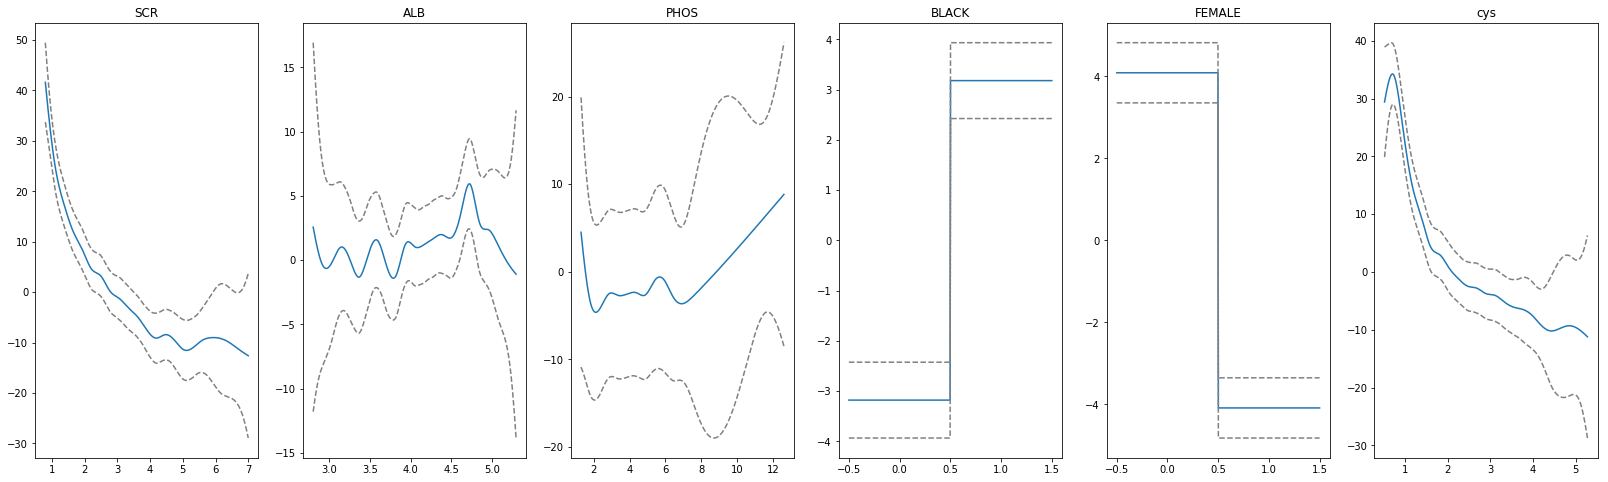

In [46]:
XX = generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, 6)
titles = X_train.columns
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])

plt.show()

It is clear that some features like **SCR** and **cys** have a fairly simple linear relationship with the **GFR** variable. There are about four features including two non-continuous variables that seem to have strong non-linear relationships though.

Also, it has the smallest $MSE$ and $AIC$ among four methods we had tested.